In [1]:
import pandas as pd
import numpy as np
import os
import pyomo.environ as en
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from Electrolyzer_v11 import build_model, GetStaticOutputs
from pyomo.util.infeasible import log_infeasible_constraints
import logging
import matplotlib.pyplot as plt

# Run using the TEMOA Environment, but with `pyomo=6.0`

st_idx = 0
#ed_idx = st_idx + 2000  # Optimal solution found when `st_idx` in [0, 2000, 4000, 6000]
#ed_idx = st_idx + 900   # Optimal solution found when `st_idx=765`
#ed_idx = st_idx + 2000  # Optimal solution found when `st_idx=2000`
ed_idx = st_idx + 2919  # Optimal solution found when `st_idx=0`
#ed_idx = st_idx + 2927   # Unbounded when when `st_idx=0`

#logging.basicConfig(filename='direct_run_2022_01_19_2000_TS.log', level=logging.INFO)

In [2]:
cost_scenario = '2020_AG'
cost_scenario_folder = os.path.join('CostScenarios', cost_scenario)

StorageData = pd.read_excel(os.path.join(cost_scenario_folder, 'StorageData.xlsx'),index_col=[0])
Discount_rate = 0.054  # Discount rate %
Lifetime = 20.0  # Lifetime in years
# Capital charge factor to annualize investment costs
CCF_val = 1/float((Discount_rate+1)/float(Discount_rate)*(1-1/(1+Discount_rate)**Lifetime))  
PVData = pd.read_excel(os.path.join(cost_scenario_folder, 'PVData.xlsx'),'Data',index_col=[0]) # PV cost data
ElyData = pd.read_excel(os.path.join(cost_scenario_folder, 'ElyData.xlsx'),'Data',index_col=[0]) # Electrolyzer cost data
H2StData = pd.read_excel(os.path.join(cost_scenario_folder, 'H2StData.xlsx'),'Data',index_col=[0]) # H2 storage cost data
cf_file = '5796_23.65_68.75_tmy.csv' # PV resource availability defined for a single location

PVAvail_tmy = pd.read_csv(cf_file,
                          index_col=0, 
                          parse_dates=True,
                          header=None,
                          squeeze=True)[st_idx:ed_idx]

 

In [3]:
productionCommitmentLB = int(np.floor(len(PVAvail_tmy) * .95)) # Minimum requirement for annual plant availability =95%
minimumProductionShutdownLength = 12 # Minimum number of hours system has to be turned down
P_Electricity = 120.0 #$/MWh # Price of exported grid electricity
LMPData = pd.Series(P_Electricity, index=range(len(PVAvail_tmy))) # 8760 x 1 vector of electricity prices

In [4]:
#a = np.random.choice(a=PVAvail_tmy.values, size=1000)
a = PVAvail_tmy.values
a[-5:]

array([0.55951229, 0.62168502, 0.65537994, 0.67164985, 0.68054534])

In [5]:
m = build_model(pvavailarray = a,
                pricearray = LMPData.values,
                dfPVData = PVData,
                dfStorData = StorageData,
                dfElyData = ElyData,
                dfH2StData = H2StData,
                CCF = CCF_val,
                productionCommitmentLB = productionCommitmentLB,
                minimumProductionShutdownLength = minimumProductionShutdownLength)

[    0.63] Resetting the tic/toc delta timer
[+   0.10] File "/Users/gta/Desktop/solar-hydrogen-model/Electrolyzer_v11.py", line 231 in build_model
defined parameters 0
[+   0.00] File "/Users/gta/Desktop/solar-hydrogen-model/Electrolyzer_v11.py", line 237 in build_model
defined PV fixcost 0
[+   0.00] File "/Users/gta/Desktop/solar-hydrogen-model/Electrolyzer_v11.py", line 260 in build_model
defined H2 fixcost 0
[+   0.03] File "/Users/gta/Desktop/solar-hydrogen-model/Electrolyzer_v11.py", line 270 in build_model
defined sys variable cost 0
[+   0.01] File "/Users/gta/Desktop/solar-hydrogen-model/Electrolyzer_v11.py", line 293 in build_model
defined objective function 0
[+   0.06] File "/Users/gta/Desktop/solar-hydrogen-model/Electrolyzer_v11.py", line 307 in build_model
defined PV constraints 0
[+   0.22] File "/Users/gta/Desktop/solar-hydrogen-model/Electrolyzer_v11.py", line 345 in build_model
defined storage constraints 0
[+   0.35] File "/Users/gta/Desktop/solar-hydrogen-model/El

In [6]:
opt = SolverFactory('cplex')
opt.options['mipgap'] = 0.1
#opt.options['timelimit'] = 60*60*1
results = opt.solve(m, tee = True)
log_infeasible_constraints(m, log_expression=True, log_variables=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.9.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2019.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/var/folders/q5/ny1flrzs6nv9nk5k366w2gtr0000gn/T/tmprvo42r4g.cplex.log' open.
CPLEX> New value for mixed integer optimality gap tolerance: 0.1
CPLEX> Problem '/var/folders/q5/ny1flrzs6nv9nk5k366w2gtr0000gn/T/tmpcx7bt7tn.pyomo.lp' read.
Read time = 0.29 sec. (9.23 ticks)
CPLEX> Problem name         : /var/folders/q5/ny1flrzs6nv9nk5k366w2gtr0000gn/T/tmpcx7bt7tn.pyomo.lp
Objective sense      : Minimize
Variables            :   43793  [Nneg: 40874,  Binary: 2919]
Objective nonzeros   :   14602
Linear constraints   :   87573  [Less: 64219,  Greater: 1,  Equal: 23353]
  Nonzeros           :  234905


In [7]:
vPVInstalledMW = [en.value(m.vPVInstalledMW) for each in range(1, len(a))]
vPVtoDCPow = [en.value(each) for each in [m.vPVtoDCPow[each] for each in range(1, len(a))]]
vPVOutput = [en.value(each) for each in [m.vPVOutput[each] for each in range(1, len(a))]]
vInvInstalledMW = [en.value(m.vInvInstalledMW) for each in range(1, len(a))]
vElyInstalledMW = [en.value(m.vElyInstalledMW) for each in range(1, len(a))]
vDCPowtoEly = [en.value(each) for each in [m.vDCPowtoEly[each] for each in range(1, len(a))]]
vCompInstalledMW = [en.value(m.vCompInstalledMW) for each in range(1, len(a))]
vH2StInstalledNumber = [en.value(m.vH2StInstalledNumber) for each in range(1, len(a))]
vH2flowProd = [en.value(each) for each in [m.vH2flowProd[each] for each in range(1, len(a))]]
vH2flowStorage = [en.value(each) for each in [m.vH2flowStorage[each] for each in range(1, len(a))]]
vDCPowtoInv = [en.value(each) for each in [m.vDCPowtoInv[each] for each in range(1, len(a))]]
vACPowtoComp = [en.value(each) for each in [m.vACPowtoComp[each] for each in range(1, len(a))]]
vACPowtoGrid = [en.value(each) for each in [m.vACPowtoGrid[each] for each in range(1, len(a))]]
vH2StStatekg = [en.value(each) for each in [m.vH2StStatekg[each] for each in range(1, len(a))]]
vH2StflowProd = [en.value(each) for each in [m.vH2StflowProd[each] for each in range(1, len(a))]]
vStInstalledMWh = [en.value(m.vStInstalledMWh['es1']) for each in range(1, len(a))]
vStInstalledMW = [en.value(m.vStInstalledMW['es1']) for each in range(1, len(a))]
vStDischarge = [en.value(each) for each in [m.vStDischarge[each, 'es1']for each in range(1, len(a))]]
vStCharge = [en.value(each) for each in [m.vStCharge[each, 'es1']for each in range(1, len(a))]]
vStSoC = [en.value(each) for each in [m.vStSoC[each, 'es1']for each in range(1, len(a))]]
vTotalH2Output = [en.value(each) for each in [m.vTotalH2Output[each] for each in range(1, len(a))]]
vH2PlantOutputSlack = [en.value(each) for each in [m.vH2PlantOutputSlack[each] for each in range(1, len(a))]]
vProductionCommitment = [en.value(each) for each in [m.vProductionCommitment[each]for each in range(1, len(a))]]
#vH2FlowtoSales = [en.value(each) for each in [m.vH2FlowtoSales[each] for each in range(1, len(a))]]
pPVCapFactor = [en.value(m.pPVCapFactor[each]) for each in range(1, len(a))]
pGridElecPrice = [en.value(m.pGridElecPrice[each]) for each in range(1, len(a))]

var_dict = {'vTotalH2Output': vTotalH2Output, 
            'vH2flowProd': vH2flowProd,
            'vH2StflowProd': vH2StflowProd,
            'vH2flowStorage': vH2flowStorage,
            'vPVInstalledMW': vPVInstalledMW,
            'vPVtoDCPow': vPVtoDCPow,
            'vPVOutput': vPVOutput,
            'vInvInstalledMW':vInvInstalledMW, 
            'vElyInstalledMW': vElyInstalledMW,
            'vDCPowtoEly': vDCPowtoEly,
            'vCompInstalledMW': vCompInstalledMW,
            'vH2StInstalledNumber': vH2StInstalledNumber,
            'vDCPowtoInv': vDCPowtoInv,
            'vACPowtoComp': vACPowtoComp,
            'vACPowtoGrid': vACPowtoGrid,
            'vH2StStatekg': vH2StStatekg,
            'vStInstalledMWh': vStInstalledMWh,
            'vStInstalledMW': vStInstalledMW,
            'vStDischarge': vStDischarge, 
            'vStCharge': vStCharge, 
            'vStSoC': vStSoC, 
            'vH2PlantOutputSlack': vH2PlantOutputSlack, 
            'vProductionCommitment': vProductionCommitment,
            'pPVCapFactor': pPVCapFactor, 
            'pGridElecPrice': pGridElecPrice}

df_DecisionVar = pd.DataFrame(var_dict)


In [8]:
pCCF = en.value(m.pCCF)
pH2DesignFlowRate = en.value(m.pH2DesignFlowRate)
pCFPlantLB = en.value(m.pCFPlantLB)
pH2LHV = en.value(m.pH2LHV)
pProductionSlackCost = en.value(m.pProductionSlackCost)
pCapCostPV = en.value(m.pCapCostPV)
pFOMCostPV = en.value(m.pFOMCostPV)
pVOMCostPV = en.value(m.pVOMCostPV)
pInvEff = en.value(m.pInvEff)
pCapCostInv = en.value(m.pCapCostInv)
pStEffChg = en.value(m.pStEffChg['es1'])
pStEffDischg = en.value(m.pStEffDischg['es1'])
pCapCostPowSt = en.value(m.pCapCostPowSt['es1'])
pCapCostEnergySt = en.value(m.pCapCostEnergySt['es1'])
pStEffChg = en.value(m.pStEffChg['es1'])
pFOMCostSt = en.value(m.pFOMCostSt['es1'])
pVOMCostSt = en.value(m.pVOMCostSt['es1'])
pDur_UB = en.value(m.pDur_UB['es1'])
pElySpecPower = en.value(m.pElySpecPower)
pCapCostEly = en.value(m.pCapCostEly)
pFOMCostEly = en.value(m.pFOMCostEly)
pVOMCostEly = en.value(m.pVOMCostEly)
pFeedH2OCostEly = en.value(m.pFeedH2OCostEly)
pCapCostH2Comp = en.value(m.pCapCostH2Comp)
pFOMCostH2Comp = en.value(m.pFOMCostH2Comp)
pCompSpecPower = en.value(m.pCompSpecPower)
pCapCostH2st = en.value(m.pCapCostH2st)
pFOMCostH2st = en.value(m.pFOMCostH2st)
pH2kgpertank = en.value(m.pH2kgpertank)

param_dict = {'pCCF': pCCF,
              'pH2DesignFlowRate': pH2DesignFlowRate,
              'pCFPlantLB': pCFPlantLB,
              'pH2LHV': pH2LHV,
              'pProductionSlackCost': pProductionSlackCost, 
              'pCapCostPV': pCapCostPV, 
              'pFOMCostPV': pFOMCostPV, 
              'pVOMCostPV': pVOMCostPV, 
              'pInvEff': pInvEff, 
              'pCapCostInv': pCapCostInv, 
              'pStEffChg': pStEffChg,
              'pStEffDischg': pStEffDischg, 
              'pCapCostPowSt': pCapCostPowSt, 
              'pCapCostEnergySt': pCapCostEnergySt,
              'pStEffChg': pStEffChg, 
              'pFOMCostSt': pFOMCostSt, 
              'pVOMCostSt': pVOMCostSt,
              'pDur_UB': pDur_UB, 
              'pElySpecPower': pElySpecPower,
              'pCapCostEly': pCapCostEly, 
              'pFOMCostEly': pFOMCostEly, 
              'pVOMCostEly': pVOMCostEly, 
              'pFeedH2OCostEly': pFeedH2OCostEly, 
              'pCapCostH2Comp': pCapCostH2Comp, 
              'pFOMCostH2Comp': pFOMCostH2Comp, 
              'pCompSpecPower': pCompSpecPower, 
              'pCapCostH2st': pCapCostH2st, 
              'pFOMCostH2st': pFOMCostH2st, 
              'pH2kgpertank': pH2kgpertank}

df_Param = pd.DataFrame(param_dict, index=['value']).T

In [9]:
df_Param

,value
pCCF,0.078735
pH2DesignFlowRate,4166.667000
pCFPlantLB,0.900000
pH2LHV,120.100000
pProductionSlackCost,0.000000
pCapCostPV,850.000000
pFOMCostPV,8500.000000
pVOMCostPV,0.000000
pInvEff,0.960000
pCapCostInv,60.000000


In [10]:
df_DecisionVar.tail().T

,2913,2914,2915,2916,2917
vTotalH2Output,0.000000,0.000000,0.000000,0.000000,0.000000
vH2flowProd,0.000000,0.000000,0.000000,0.000000,0.000000
vH2StflowProd,0.000000,0.000000,0.000000,0.000000,0.000000
vH2flowStorage,0.000000,0.000000,0.000000,0.000000,1453.127821
vPVInstalledMW,9649.669987,9649.669987,9649.669987,9649.669987,9649.669987
vPVtoDCPow,4000.557184,5399.108952,5999.055255,6324.200165,6481.199377
vPVOutput,4000.557184,5399.108952,5999.055255,6324.200165,6481.199377
vInvInstalledMW,6397.616690,6397.616690,6397.616690,6397.616690,6397.616690
vElyInstalledMW,517.672455,517.672455,517.672455,517.672455,517.672455
vDCPowtoEly,0.000000,0.000000,0.000000,0.000000,83.582687


In [11]:
df_DecisionVar.describe().T

,count,mean,std,min,25%,50%,75%,max
vTotalH2Output,2918.0,3.563657e+03,8.150409e+02,0.000000e+00,3750.000300,3750.000300,3750.000300,3.750000e+03
vH2flowProd,2918.0,1.640063e+03,1.850994e+03,0.000000e+00,0.000000,0.000000,3750.000300,3.750000e+03
vH2StflowProd,2918.0,1.923594e+03,1.865216e+03,0.000000e+00,0.000000,3750.000300,3750.000300,3.750000e+03
vH2flowStorage,2918.0,1.922584e+03,2.486513e+03,0.000000e+00,0.000000,0.000000,5250.000420,5.250000e+03
vPVInstalledMW,2918.0,9.649670e+03,6.785993e-10,9.649670e+03,9649.669987,9649.669987,9649.669987,9.649670e+03
vPVtoDCPow,2918.0,2.255615e+03,2.755362e+03,0.000000e+00,0.000000,0.000000,5534.171793,6.915289e+03
vPVOutput,2918.0,2.255615e+03,2.755362e+03,0.000000e+00,0.000000,0.000000,5534.171793,6.915289e+03
vInvInstalledMW,2918.0,6.397617e+03,1.937556e-10,6.397617e+03,6397.616690,6397.616690,6397.616690,6.397617e+03
vElyInstalledMW,2918.0,5.176725e+02,1.694224e-11,5.176725e+02,517.672455,517.672455,517.672455,5.176725e+02
vDCPowtoEly,2918.0,2.049205e+02,2.412883e+02,0.000000e+00,0.000000,0.000000,517.672455,5.176725e+02


In [12]:
df_DecisionVar[df_DecisionVar['vH2StStatekg'] >=52000].head().T

,18,42,66,90,114
vTotalH2Output,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300
vH2flowProd,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300
vH2StflowProd,0.000000,0.000000,0.000000,0.000000,0.000000
vH2flowStorage,5250.000420,5250.000420,5250.000420,5250.000420,5250.000420
vPVInstalledMW,9649.669987,9649.669987,9649.669987,9649.669987,9649.669987
vPVtoDCPow,863.204572,1041.330905,878.208487,922.350770,961.800103
vPVOutput,863.204572,1041.330905,878.208487,922.350770,961.800103
vInvInstalledMW,6397.616690,6397.616690,6397.616690,6397.616690,6397.616690
vElyInstalledMW,517.672455,517.672455,517.672455,517.672455,517.672455
vDCPowtoEly,517.672455,517.672455,517.672455,517.672455,517.672455


In [13]:
df_DecisionVar.iloc[410:425].T

,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424
vTotalH2Output,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3.750000e+03,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300
vH2flowProd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300
vH2StflowProd,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3750.000300,3.750000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vH2flowStorage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,5250.000420,5250.000420,5250.000420,5250.000420,5250.000420,5250.000420,5250.000420,5250.000420
vPVInstalledMW,9649.669987,9649.669987,9649.669987,9649.669987,9649.669987,9649.669987,9.649670e+03,9649.669987,9649.669987,9649.669987,9649.669987,9649.669987,9649.669987,9649.669987,9649.669987
vPVtoDCPow,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2057.912734,4648.024837,5332.452221,5452.896392,5541.909478,5614.311204,5759.870646,5756.107637
vPVOutput,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2057.912734,4648.024837,5332.452221,5452.896392,5541.909478,5614.311204,5759.870646,5756.107637
vInvInstalledMW,6397.616690,6397.616690,6397.616690,6397.616690,6397.616690,6397.616690,6.397617e+03,6397.616690,6397.616690,6397.616690,6397.616690,6397.616690,6397.616690,6397.616690,6397.616690
vElyInstalledMW,517.672455,517.672455,517.672455,517.672455,517.672455,517.672455,5.176725e+02,517.672455,517.672455,517.672455,517.672455,517.672455,517.672455,517.672455,517.672455
vDCPowtoEly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,517.672455,517.672455,517.672455,517.672455,517.672455,517.672455,517.672455,517.672455


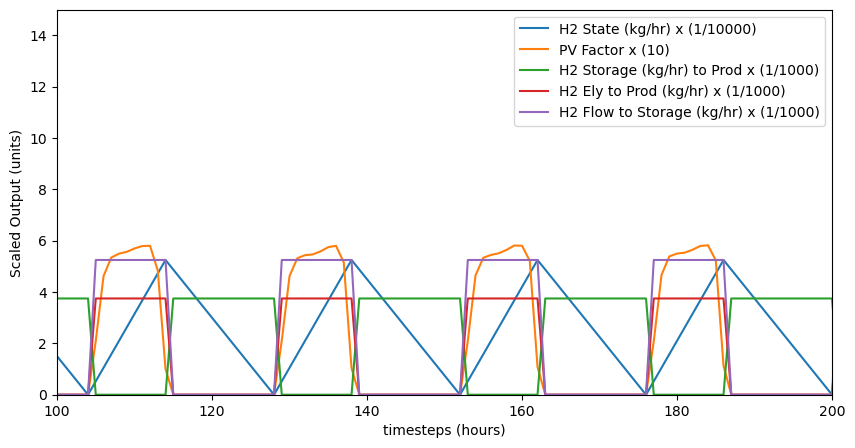

In [14]:
plt.figure(figsize=(10, 5))
plt.plot([each/10000 for each in df_DecisionVar['vH2StStatekg'].values.tolist()], 
         label='H2 State (kg/hr) x (1/10000)')
plt.plot([each*10 for each in df_DecisionVar['pPVCapFactor'].values.tolist()], label='PV Factor x (10)')
plt.plot([each/1000 for each in df_DecisionVar['vH2StflowProd'].values.tolist()], label='H2 Storage (kg/hr) to Prod x (1/1000)')
plt.plot([each/1000 for each in df_DecisionVar['vH2flowProd'].values.tolist()], label='H2 Ely to Prod (kg/hr) x (1/1000)')
plt.plot([each/1000 for each in df_DecisionVar['vH2flowStorage'].values.tolist()], label='H2 Flow to Storage (kg/hr) x (1/1000)')

plt.ylim(0, 15)

plt.xlim(100, 200)
plt.xlabel('timesteps (hours)')
plt.ylabel('Scaled Output (units)')
plt.legend()
plt.show()